In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm

In [2]:
from utils import get_device
from trainer import Trainer
from tester import Tester
from dataloader import Cifar10D
from transformations import std_transforms,train_transforms

Device selected cuda


In [3]:
device = get_device()
print(device)

cuda


In [4]:
class Module0(nn.Module):
    def __init__(self,norm_name:str,dropout_rate:float=0.01):
        super(Module0,self).__init__()

        self.dropout_rate = dropout_rate
        self.norm_name    = norm_name

        self.conv1 = self.ConvLayer(in_=3,out_=8,k=3,s=1,p=1).extend(
                            self.ConvLayer(in_=8,out_=16,k=3,s=1,p=1)                
                        )
        
        self.trans1 = nn.Sequential(
                            nn.MaxPool2d(2,2),
                            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=1,stride=1,bias=False)
                    )

        self.conv2 = self.ConvLayer(in_=8,out_=16,k=3,s=1,p=1).extend(
                            self.ConvLayer(in_=16,out_=32,k=3,s=1,p=1)
                    )
        
        self.trans2 = nn.Sequential(
                            nn.MaxPool2d(2,2),
                            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,stride=1,bias=False)
                    )
        
        self.conv3 = self.ConvLayer(in_=16,out_=32,k=3,s=1,p=1).extend(
                        self.ConvLayer(in_=32,out_=64,k=3,s=1,p=1)
                        ).extend(
                                self.ConvLayer(in_=64,out_=128,k=3,s=1,p=1)
                        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=10,kernel_size=1,bias=False)
        
    def ConvLayer(
                self,
                in_:int,
                out_:int,
                k:int,
                s:int,
                p:int,
                b=False
    )->torch.nn.modules.container.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels=in_,out_channels=out_,kernel_size=k,stride=s,padding=p,bias=b),
            self.get_norm(out_=out_),
            nn.ReLU(inplace=True),
            nn.Dropout2d(self.dropout_rate)
        )

    def get_norm(self,out_):
        if self.norm_name=='bn':
            return nn.BatchNorm2d(num_features=out_)
        else:
            raise ValueError('Pass proper normalisation')

    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = self.conv4(x)
        logit = F.log_softmax(x.view(-1,10),dim=1) 
        return logit

In [5]:
cifar10 = Cifar10D(batch_size=128,is_cuda_available=True)

train_loader = cifar10.get_loader(root='../data/',download=False,transform=train_transforms, train=True)
test_loader = cifar10.get_loader(root='../data/',download=False,transform=std_transforms, train=False)

In [6]:
model = Module0(norm_name='bn',dropout_rate=0.1).to(device)

In [7]:
# Data to plot accuracy and loss graphs (INIT)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # print(pred.shape)
    # print(target.shape)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


In [8]:
%%time

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)
# New Line
criterion =  F.nll_loss
num_epochs =20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=1.6958 Batch_id=390 Accuracy=29.63: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:47<00:00,  8.29it/s]


Test set: Average loss: 1.6438, Accuracy: 3885/10000 (38.8500%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2


Train: Loss=1.5356 Batch_id=390 Accuracy=37.82: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:44<00:00,  8.73it/s]


Test set: Average loss: 1.4414, Accuracy: 4472/10000 (44.7200%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3


Train: Loss=1.6105 Batch_id=390 Accuracy=42.60: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:43<00:00,  8.92it/s]


Test set: Average loss: 1.3636, Accuracy: 5015/10000 (50.1500%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4


Train: Loss=1.3092 Batch_id=390 Accuracy=46.18: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:48<00:00,  8.08it/s]


Test set: Average loss: 1.2410, Accuracy: 5459/10000 (54.5900%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5


Train: Loss=1.4383 Batch_id=390 Accuracy=48.52: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.61it/s]


Test set: Average loss: 1.2100, Accuracy: 5611/10000 (56.1100%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6


Train: Loss=1.2466 Batch_id=390 Accuracy=50.65: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:44<00:00,  8.88it/s]


Test set: Average loss: 1.1091, Accuracy: 6013/10000 (60.1300%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=1.3235 Batch_id=390 Accuracy=53.51: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:43<00:00,  9.03it/s]


Test set: Average loss: 1.0424, Accuracy: 6270/10000 (62.7000%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=1.1174 Batch_id=390 Accuracy=54.56: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:56<00:00,  6.98it/s]


Test set: Average loss: 1.0326, Accuracy: 6309/10000 (63.0900%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=1.3331 Batch_id=390 Accuracy=55.05: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.50it/s]


Test set: Average loss: 1.0153, Accuracy: 6400/10000 (64.0000%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=1.0429 Batch_id=390 Accuracy=55.51: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:49<00:00,  7.98it/s]


Test set: Average loss: 1.0072, Accuracy: 6398/10000 (63.9800%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=1.2982 Batch_id=390 Accuracy=55.93: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


Test set: Average loss: 0.9917, Accuracy: 6470/10000 (64.7000%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=1.1618 Batch_id=390 Accuracy=55.89: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:44<00:00,  8.82it/s]


Test set: Average loss: 0.9828, Accuracy: 6466/10000 (64.6600%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=1.1315 Batch_id=390 Accuracy=56.38: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:44<00:00,  8.84it/s]


Test set: Average loss: 0.9820, Accuracy: 6504/10000 (65.0400%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=1.2439 Batch_id=390 Accuracy=56.16: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.66it/s]


Test set: Average loss: 0.9806, Accuracy: 6515/10000 (65.1500%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=1.3601 Batch_id=390 Accuracy=56.19: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:48<00:00,  8.08it/s]


Test set: Average loss: 0.9819, Accuracy: 6511/10000 (65.1100%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=1.2694 Batch_id=390 Accuracy=56.54: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.39it/s]


Test set: Average loss: 0.9772, Accuracy: 6537/10000 (65.3700%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=1.1235 Batch_id=390 Accuracy=56.24: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:44<00:00,  8.84it/s]


Test set: Average loss: 0.9786, Accuracy: 6520/10000 (65.2000%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=1.2700 Batch_id=390 Accuracy=56.59: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.53it/s]


Test set: Average loss: 0.9782, Accuracy: 6515/10000 (65.1500%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 19


Train: Loss=1.0291 Batch_id=390 Accuracy=56.66: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:43<00:00,  8.91it/s]


Test set: Average loss: 0.9753, Accuracy: 6535/10000 (65.3500%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 20


Train: Loss=1.3384 Batch_id=390 Accuracy=56.55: 100%|████████████████████████████████████████████████████████████████████| 391/391 [00:44<00:00,  8.69it/s]


Test set: Average loss: 0.9758, Accuracy: 6531/10000 (65.3100%)

Adjusting learning rate of group 0 to 1.0000e-04.
CPU times: total: 5min 58s
Wall time: 24min 29s


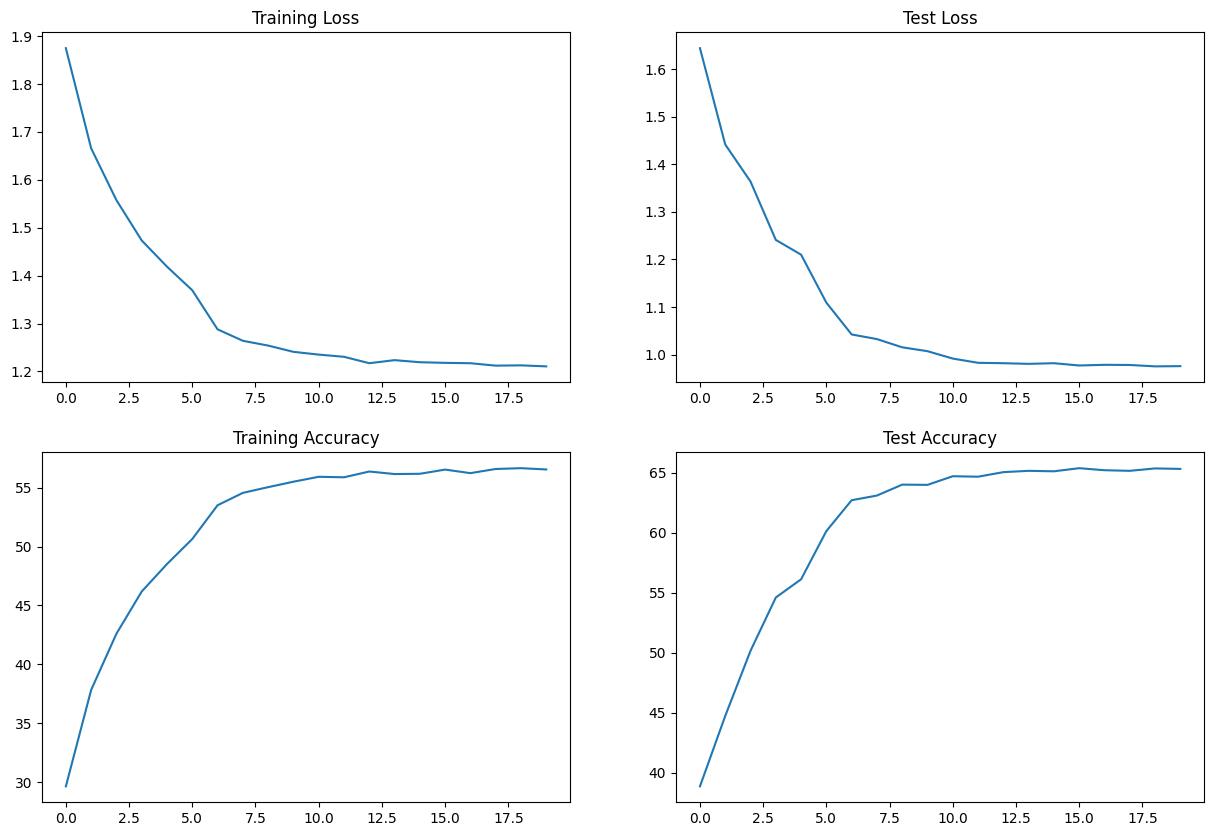

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [10]:
from utils import show_egs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\muthu\Documents\TSAI\session 8\utils.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

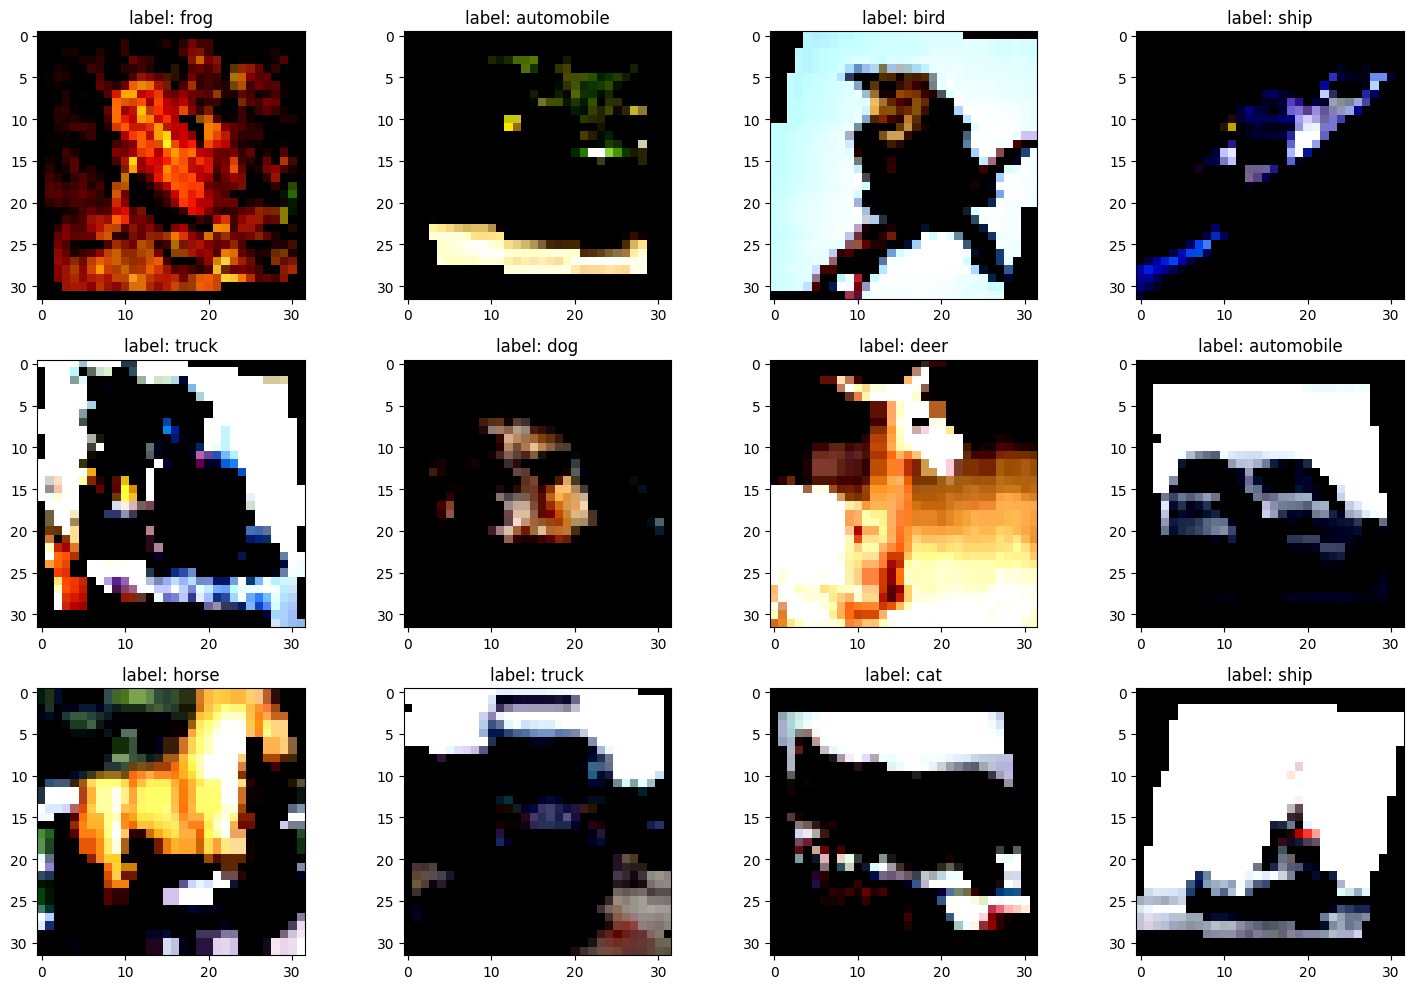

In [11]:
show_egs(train_loader,figsize=(15,10))

In [12]:
def get_misclassified_images(model,test_loader):
    model.eval()
    images = []
    predictions  = []
    labels = []

    with torch.no_grad():
        for inputs,targets in test_loader:
            inputs  = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            _,pred = torch.max(outputs,1)

            for i in range(len(pred)):
                if pred[i]!=targets[i]:
                    images.append(inputs[i])
                    predictions.append(pred[i])
                    labels.append(targets[i])
    return images,predictions,labels

In [13]:
imgs, preds, lbls = get_misclassified_images(model,test_loader)

In [14]:
def show_misclassified_images( images, predictions, labels, classes):
    assert len(images) == len(predictions) == len(labels)

    fig = plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        sub = fig.add_subplot(len(images) // 5, 5, i + 1)
        image = images[i]
        image = image.T
        npimg = image.cpu().numpy().squeeze()
        plt.imshow(npimg, cmap="gray")
        predicted = classes[predictions[i]]
        correct = classes[labels[i]]
        sub.set_title(
            "Correct class: {}\nPredicted class: {}".format(correct, predicted)
        )
    plt.tight_layout()

C:\Users\muthu\AppData\Local\Temp\ipykernel_25480\2406507017.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  image = image.T
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Cli

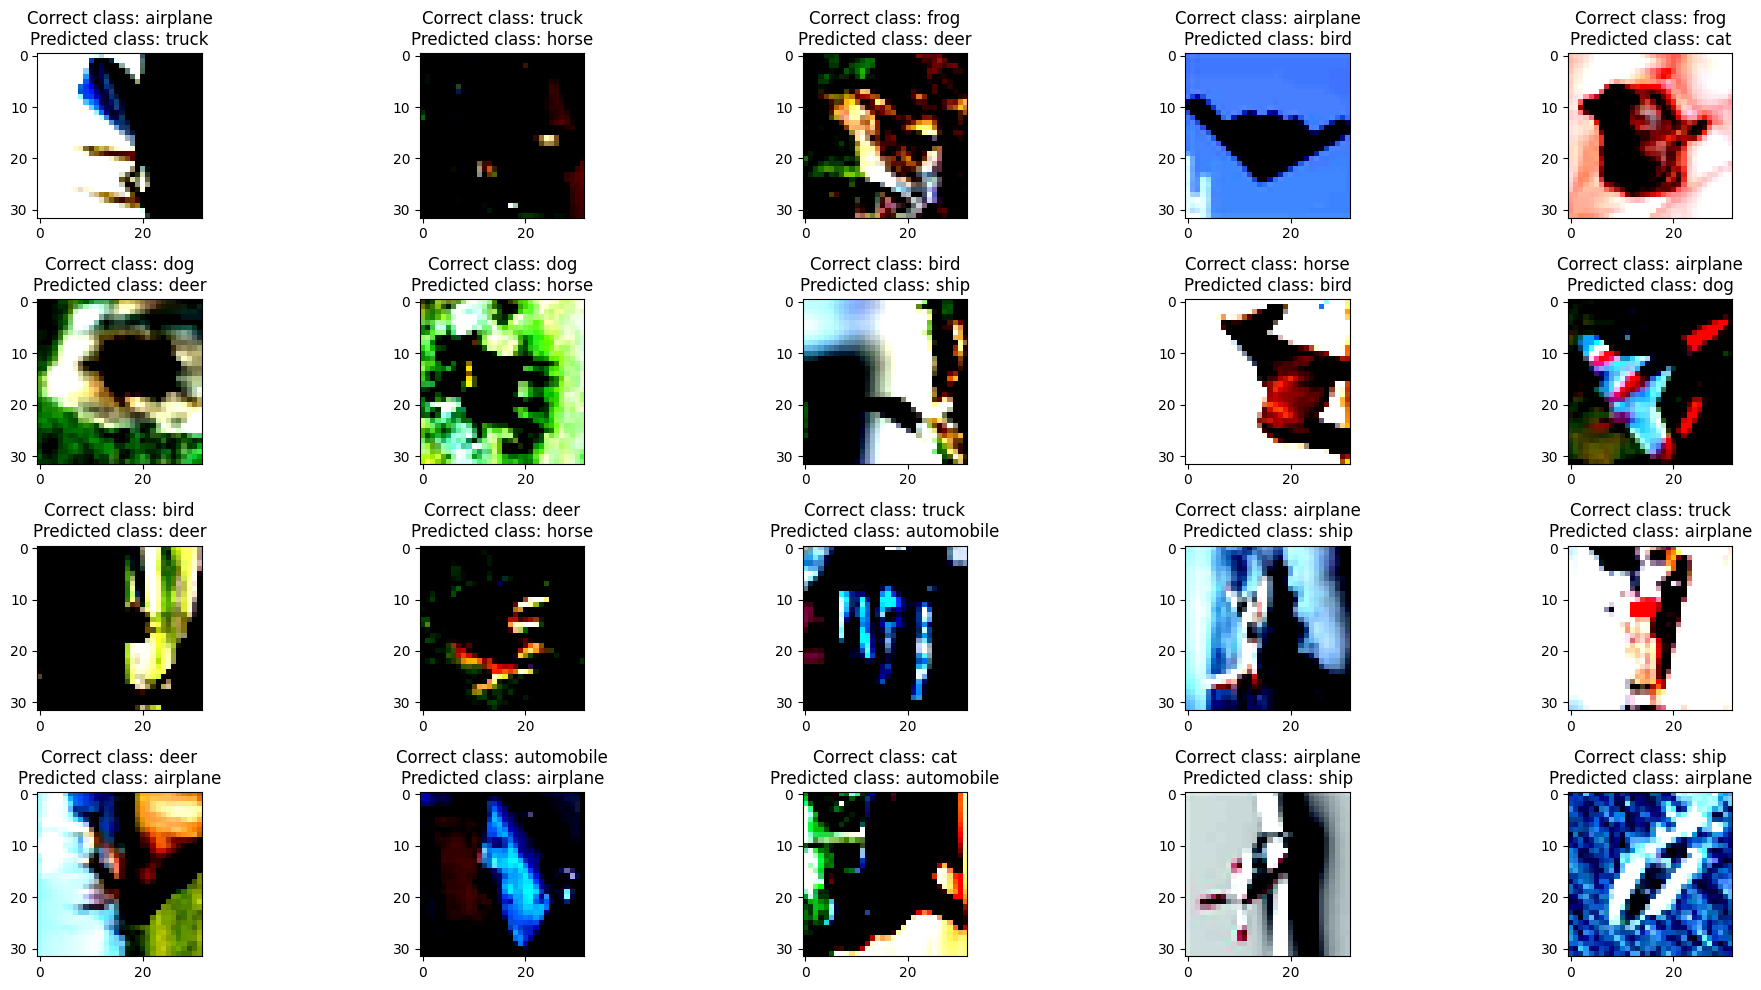

In [15]:
show_misclassified_images(images=imgs[:20],predictions=preds[:20],labels=lbls[:20],classes=cifar10.classes)